In [1]:
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
from tqdm import tqdm

In [2]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

OUTPUT_DIR = os.path.join(PROJECT_ROOT, "output")
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
FIG_DIR = os.path.join(PROJECT_ROOT, "figs")

os.makedirs(FIG_DIR, exist_ok=True)
X_INIT = 45_910
step_x = 2

In [3]:
import glob, os, pprint
pprint.pprint(glob.glob(os.path.join(OUTPUT_DIR, "run_*")))


['/home/arcadia/FCFD-Laser/output/run_20250922_141524_Power_80.0%']


In [4]:
def get_latest_run_dir(power, base_path=OUTPUT_DIR):
    pattern = os.path.join(base_path, f"run_*_Power_{power}%")
    run_dirs = sorted(glob.glob(pattern))
    if not run_dirs:
        raise FileNotFoundError(f"No run dir for Power={power}%")
    return run_dirs[-1]  # latest by name (timestamped)

def get_data(power, idx, base_path=OUTPUT_DIR):
    run_dir = get_latest_run_dir(power, base_path)
    converted_path = os.path.join(run_dir, "converted")
    converted_files = glob.glob(os.path.join(converted_path, "*.root"))
    if not converted_files:
        raise FileNotFoundError(f"No .root files found in {converted_path}")
    sorted_files = sorted(
        converted_files,
        key=lambda path: int(re.search(r'run(\d+)\.root', path).group(1))
    )
    data_path = sorted_files[idx]
    with ur.open(data_path) as data_file:
        data = data_file["pulse"]
        channel_data = data.arrays(["channel"], library="np")
        time_data = data.arrays(["time"], library="np")
    return channel_data["channel"], time_data["time"]


In [5]:
power = 80.0
idx = 0
channel_data, time_data = get_data(power, idx)

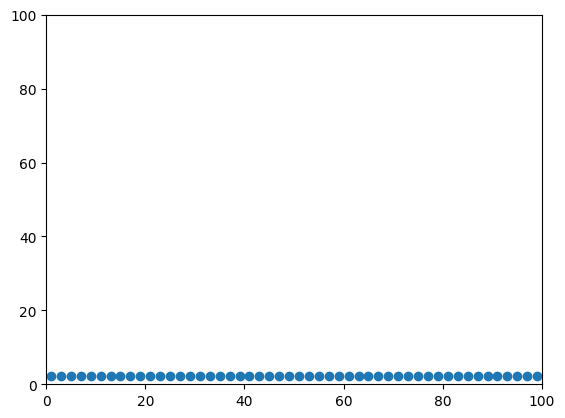

In [6]:
iEvent = 0
ICHANNEL = 0
y_waveform = channel_data[iEvent, ICHANNEL, :]
t = np.arange(y_waveform.shape[0])
plt.scatter(t, time_data[iEvent, ICHANNEL, :], label=f"Ch {ICHANNEL+1}")
plt.xlim(0, 100)
plt.ylim([0, 100])
plt.show()

/home/arcadia/.local/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: overflow encountered in multiply
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/arcadia/.local/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/arcadia/.local/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: overflow encountered in multiply
  b = (dx2 - dx1) / (dx1 * dx2)
/home/arcadia/.local/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: overflow encountered in multiply
  c = dx1 / (dx2 * (dx1 + dx2))
/home/arcadia/.local/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/arcadia/.local/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:1253: RuntimeWarning: invalid value encountered in multiply
  o

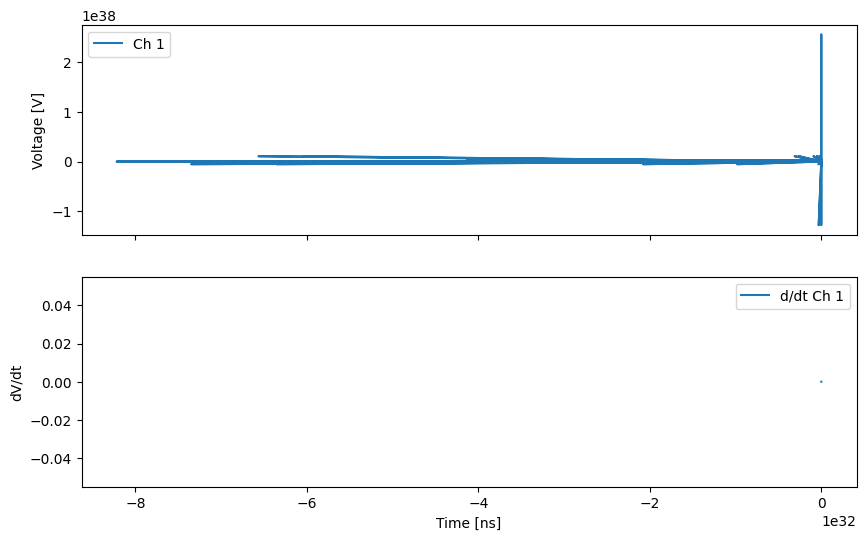

In [7]:
iEvent = 2
ICHANNEL = 0

y_waveform = channel_data[iEvent, ICHANNEL, :]
time       = time_data   [iEvent, ICHANNEL, :]
dy_dt = np.gradient(y_waveform.astype(np.float64, copy=False), time, edge_order=2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax1.plot(time, y_waveform,     label=f"Ch {ICHANNEL+1}")
ax2.plot(time, dy_dt, label=f"d/dt Ch {ICHANNEL+1}")

ax1.set_ylabel("Voltage [V]")
ax2.set_ylabel("dV/dt")
ax2.set_xlabel("Time (arb units)" if time.dtype==int else "Time [ns]")
ax1.legend(); ax2.legend()

FIG_DIR = os.path.join(OUTPUT_DIR, "figs"); os.makedirs(FIG_DIR, exist_ok=True)
fig.savefig(os.path.join(FIG_DIR, f"event{iEvent}_ch{ICHANNEL+1}.png"))
plt.show()


/tmp/arcadia/ipykernel_210914/35230783.py:7: RuntimeWarning: invalid value encountered in cast
  dy_dt = np.gradient(y_waveform.astype(np.float64, copy=False), 1.0, edge_order=2)
/home/arcadia/.local/lib/python3.9/site-packages/matplotlib/cbook.py:1398: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


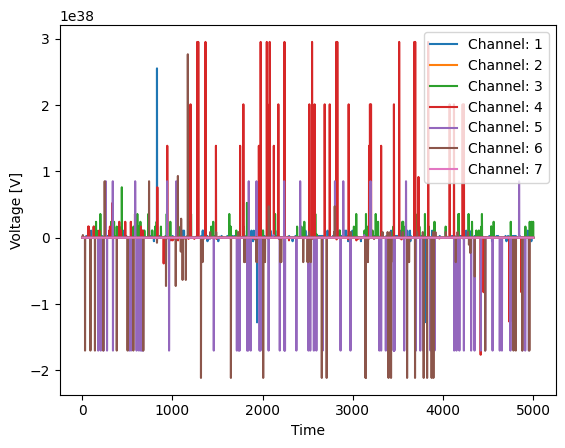

In [9]:
iEvent = 2
ICHANNEL = 0

for ICHANNEL in range(7):
    y_waveform = channel_data[iEvent, ICHANNEL, :]
    t = np.arange(y_waveform.shape[0])
    dy_dt = np.gradient(y_waveform.astype(np.float64, copy=False), 1.0, edge_order=2)

    plt.plot(t, y_waveform, label = f"Channel: {ICHANNEL+1}")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Voltage [V]")
# plt.ylim([0.1, 0.3])
plt.savefig(f"{FIG_DIR}event{iEvent}_channel{ICHANNEL+1}.png")
plt.show()

nan
nan
nan


/tmp/arcadia/ipykernel_209160/1697871753.py:20: RuntimeWarning: Mean of empty slice.
  mean_amp =  y_ana[rising_edge_idx:falling_edge_idx].mean()
/home/arcadia/.local/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


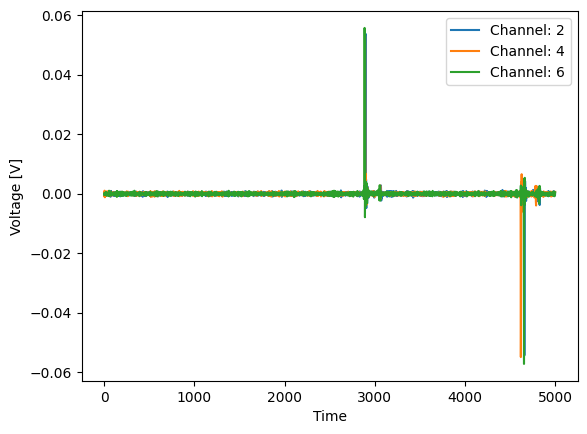

In [62]:
iEvent = 0
ICHANNEL = 0

grad_thr = 0.2

for ICHANNEL in list(range(1,7,2)):
    y_ana = channel_data[iEvent, ICHANNEL, :]
    y_dig = channel_data[iEvent, ICHANNEL+1, :]
    t = np.arange(y_dig.shape[0])
    dy_dt = np.gradient(y_dig.astype(np.float64, copy=False), 1.0, edge_order=2)

    rising_mask = dy_dt > grad_thr
    falling_mask = dy_dt < -grad_thr

    # Find first rising and falling edge
    rising_edge_idx = np.argmax(rising_mask)  # returns 0 if no True found
    falling_edge_idx = np.argmax(falling_mask & (np.arange(len(dy_dt)) > rising_edge_idx + 1))


    mean_amp =  y_ana[rising_edge_idx:falling_edge_idx].mean()
    
    print(mean_amp)
    plt.plot(t, dy_dt, label = f"Channel: {ICHANNEL+1}")


plt.legend()
plt.xlabel("Time")
plt.ylabel("Voltage [V]")
# plt.ylim([0.1, 0.3])
plt.show()

In [29]:
def find_pulse_edges(ch, noise_window=100, noise_factor=5, peak_fraction=0.2):
    dy_dt = np.gradient(ch.astype(np.float64, copy=False), edge_order=2)

    baseline = dy_dt[:noise_window]
    sigma = np.std(baseline)

    thr_noise = noise_factor * sigma
    thr_peak  = peak_fraction * np.max(np.abs(dy_dt))

    thr_pos = max(thr_noise, thr_peak)     
    thr_neg = -max(thr_noise, thr_peak)    

    rise_candidates = np.where(dy_dt > thr_pos)[0]
    fall_candidates = np.where(dy_dt < thr_neg)[0]

    rise_idx, fall_idx = None, None
    if rise_candidates.size > 0:
        rise_idx = rise_candidates[0]  
    if fall_candidates.size > 0:
        fall_idx = fall_candidates[-1]

    return rise_idx, fall_idx, thr_pos, thr_neg


Channel: 4, Rise: 2891, Fall: 4623, Mean Amp: 0.44229012727737427


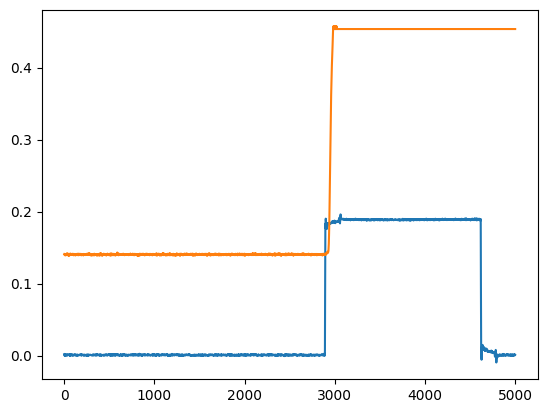

In [36]:
grad_thr = 0.02
n_events = 1
ICHANNEL = 3

y_ana = out_data["channel"][iEvent, ICHANNEL, :]
y_dig = out_data["channel"][iEvent, ICHANNEL + 1, :]

rise_idx, fall_idx, thr_pos, thr_neg = find_pulse_edges(y_dig, noise_window=100, noise_factor=5, peak_fraction=0.2)
mean_amp = y_ana[rise_idx:fall_idx].mean()

print(f"Channel: {ICHANNEL+1}, Rise: {rise_idx}, Fall: {fall_idx}, Mean Amp: {mean_amp}")
plt.plot(y_dig, label = f"Channel: {ICHANNEL+1}")
plt.plot(y_ana, label = f"Channel: {ICHANNEL+1}")
plt.show()

[1, 3, 5]
Channel: 2, Rise: 2897, Fall: 4662, Mean Amp: 0.31023919582366943


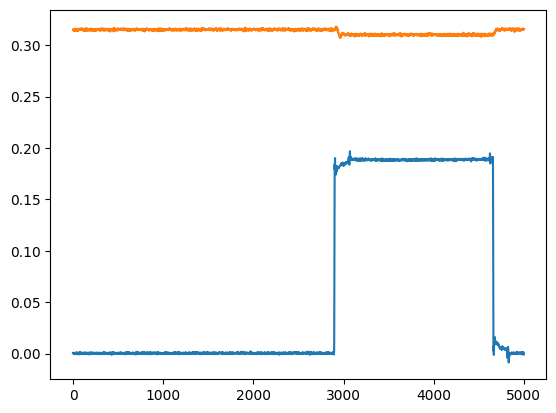

Channel: 4, Rise: 2891, Fall: 4623, Mean Amp: 0.44229012727737427


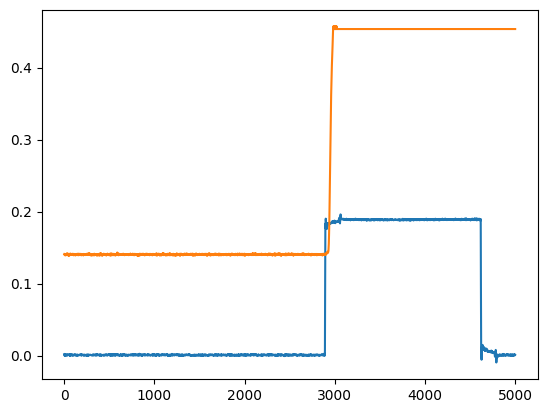

Channel: 6, Rise: 2886, Fall: 4658, Mean Amp: 0.4461575448513031


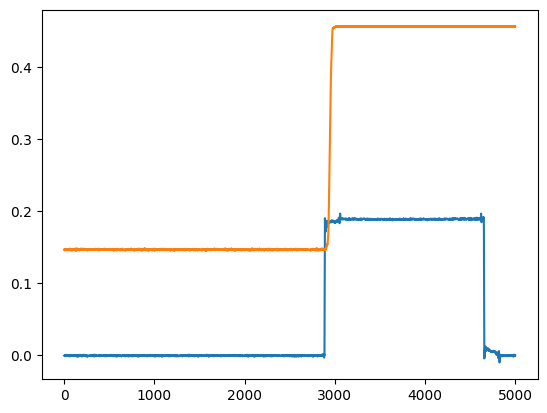

In [35]:
grad_thr = 0.02
n_events = 1
channels = list(range(1, 7, 2))  
print(channels)
amp_by_channel = {ch + 1: [] for ch in channels}

for iEvent in range(n_events):
    for ICHANNEL in channels:
        y_ana = out_data["channel"][iEvent, ICHANNEL, :]
        y_dig = out_data["channel"][iEvent, ICHANNEL + 1, :]

        rise_idx, fall_idx, thr_pos, thr_neg = find_pulse_edges(y_dig, noise_window=100, noise_factor=5, peak_fraction=0.2)

        mean_amp = y_ana[rise_idx:fall_idx].mean()
        amp_by_channel[ICHANNEL + 1].append(mean_amp)

        print(f"Channel: {ICHANNEL+1}, Rise: {rise_idx}, Fall: {fall_idx}, Mean Amp: {mean_amp}")
        plt.plot(y_dig, label = f"Channel: {ICHANNEL+1}")
        plt.plot(y_ana, label = f"Channel: {ICHANNEL+1}")
        plt.show()

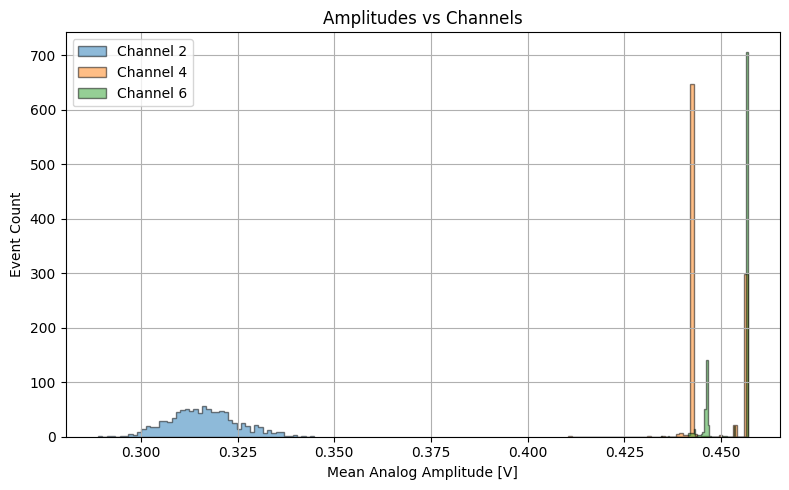

In [31]:
plt.figure(figsize=(8, 5))

for ch in sorted(amp_by_channel):
    amps = amp_by_channel[ch]
    plt.hist(amps, bins=50, alpha=0.5, label=f"Channel {ch}", edgecolor='black', histtype='stepfilled')

plt.xlabel('Mean Analog Amplitude [V]')
plt.ylabel('Event Count')
plt.title('Amplitudes vs Channels')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


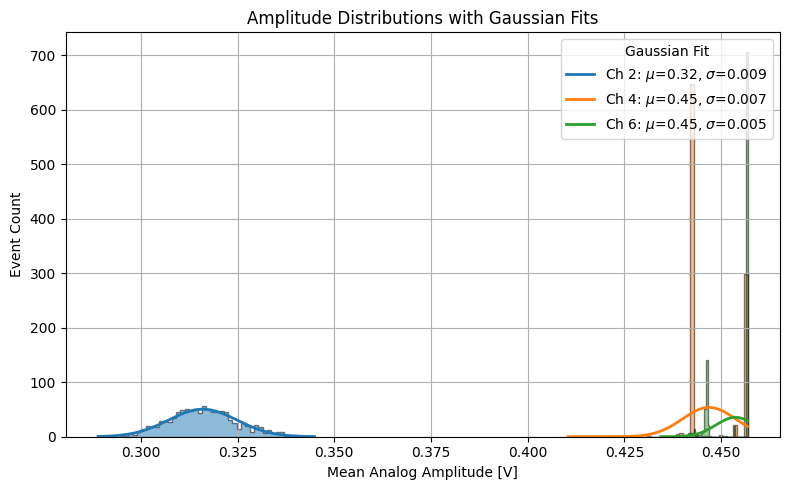

In [32]:
import matplotlib as mpl
import matplotlib.lines as mlines

plt.figure(figsize=(8, 5))

colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
stats_handles = []

for i, ch in enumerate(sorted(amp_by_channel)):
    amps = np.asarray(amp_by_channel[ch], dtype=np.float64)
    amps = amps[np.isfinite(amps)]
    if amps.size < 2:
        continue  # not enough samples to fit

    color = colors[i % len(colors)]

    # Histogram
    n, bins, patches = plt.hist(
        amps, bins=50, alpha=0.5,
        edgecolor='black', histtype='stepfilled', color=color
    )

    # Gaussian fit
    try:
        from scipy.stats import norm
        mu, sigma = norm.fit(amps)
        pdf = lambda x: norm.pdf(x, mu, sigma)
    except Exception:
        mu = float(amps.mean())
        sigma = float(amps.std(ddof=0))
        if sigma == 0.0:
            continue
        pdf = lambda x: (1.0/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mu)/sigma)**2)

    # Fit overlay
    a_min, a_max = amps.min(), amps.max()
    if a_min == a_max:
        continue
    bin_width = (a_max - a_min) / 50.0
    x_fit = np.linspace(a_min, a_max, 1000)
    y_fit = amps.size * bin_width * pdf(x_fit)
    plt.plot(x_fit, y_fit, color=color, linewidth=2)

    # Stats-only legend entry
    stats_handles.append(
        mlines.Line2D([], [], color=color, linewidth=2,
                      label=rf"Ch {ch}: $\mu$={mu:.2g}, $\sigma$={sigma:.3f}")
    )

# Only stats legend
if stats_handles:
    plt.legend(handles=stats_handles, loc='upper right', title='Gaussian Fit')

plt.xlabel('Mean Analog Amplitude [V]')
plt.ylabel('Event Count')
plt.title('Amplitude Distributions with Gaussian Fits')
plt.grid(True)
plt.tight_layout()
plt.show()


[1, 3, 5]


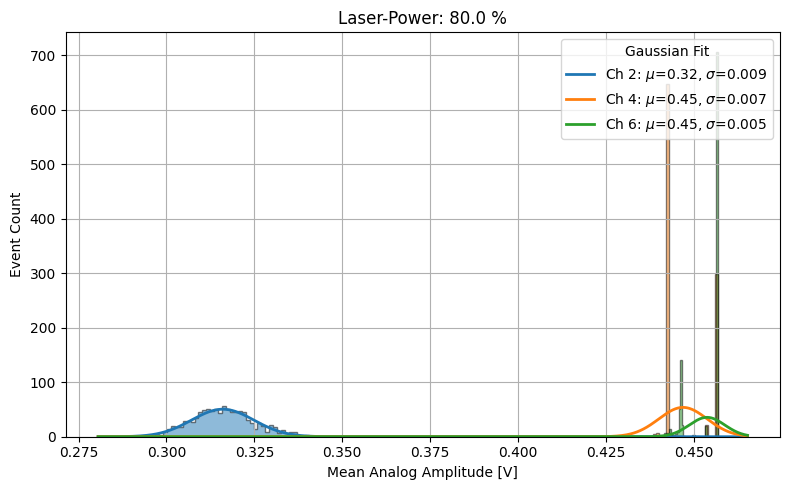

FileNotFoundError: No run dir for Power=82.5%

In [33]:
power_list = np.arange(80, 95.1, 2.5)
idx = 0

for power in power_list:
    out_data = get_data(power, idx)

    grad_thr = 0.02
    n_events = 1000
    channels = list(range(1, 7, 2))  
    print(channels)
    amp_by_channel = {ch + 1: [] for ch in channels}

    for iEvent in range(n_events):
        for ICHANNEL in channels:
            y_ana = out_data["channel"][iEvent, ICHANNEL, :]
            y_dig = out_data["channel"][iEvent, ICHANNEL + 1, :]

            rise_idx, fall_idx, thr_pos, thr_neg = find_pulse_edges(y_dig, noise_window=100, noise_factor=5, peak_fraction=0.2)

            mean_amp = y_ana[rise_idx:fall_idx].mean()
            amp_by_channel[ICHANNEL + 1].append(mean_amp)

    plt.figure(figsize=(8, 5))

    colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
    stats_handles = []
    fit_parameters = []

    for i, ch in enumerate(sorted(amp_by_channel)):
        amps = np.asarray(amp_by_channel[ch], dtype=np.float64)
        amps = amps[np.isfinite(amps)]
        if amps.size < 2:
            continue  # not enough samples to fit

        color = colors[i % len(colors)]

        # Histogram
        n, bins, patches = plt.hist(
            amps, bins=50, alpha=0.5,
            edgecolor='black', histtype='stepfilled', color=color
        )

        # Gaussian fit
        try:
            from scipy.stats import norm
            mu, sigma = norm.fit(amps)
            pdf = lambda x: norm.pdf(x, mu, sigma)
        except Exception:
            mu = float(amps.mean())
            sigma = float(amps.std(ddof=0))
            if sigma == 0.0:
                continue
            pdf = lambda x: (1.0/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mu)/sigma)**2)

        bin_width = bins[1] - bins[0]
        fit_parameters.append({
            'mu': mu,
            'sigma': sigma,
            'color': color,
            'norm_factor': amps.size * bin_width
        })
        # Stats-only legend entry
        stats_handles.append(
            mlines.Line2D([], [], color=color, linewidth=2,
                        label=rf"Ch {ch}: $\mu$={mu:.2g}, $\sigma$={sigma:.3f}")
        )

    plot_xmin, plot_xmax = plt.xlim()
    x_fit = np.linspace(plot_xmin, plot_xmax, 1000)
    for params in fit_parameters:
        # Calculate the y-values for the fit using the full x-range
        y_fit = norm.pdf(x_fit, params['mu'], params['sigma']) * params['norm_factor']
        plt.plot(x_fit, y_fit, color=params['color'], linewidth=2)

    # Only stats legend
    if stats_handles:
        plt.legend(handles=stats_handles, loc='upper right', title='Gaussian Fit')

    plt.xlabel('Mean Analog Amplitude [V]')
    plt.ylabel('Event Count')
    plt.title(f'Laser-Power: {power} %')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

